In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sympy import symbols, Eq, solve
import sympy as sym
import math
from IPython.display import display
pd.options.display.float_format = '{:,.2f}'.format
from numpy.linalg import inv
from scipy.optimize import curve_fit
from scipy.optimize import fsolve

In [2]:
df = pd.read_csv("data.csv")

## Experimental Dataset Used:

In [3]:
print(df)

    T(deg C)   x1   y1
0      72.50 0.00 0.00
1      67.02 0.05 0.17
2      64.40 0.10 0.32
3      60.23 0.20 0.53
4      56.65 0.30 0.68
5      53.34 0.40 0.80
6      50.40 0.50 0.86
7      48.12 0.60 0.92
8      46.05 0.70 0.95
9      44.15 0.80 0.98
10     42.50 0.90 0.99
11     41.90 0.95 1.00
12     41.20 1.00 1.00


In [4]:
df['T(K)']=df['T(deg C)']+273.15
print(df)

    T(deg C)   x1   y1   T(K)
0      72.50 0.00 0.00 345.65
1      67.02 0.05 0.17 340.17
2      64.40 0.10 0.32 337.55
3      60.23 0.20 0.53 333.38
4      56.65 0.30 0.68 329.80
5      53.34 0.40 0.80 326.49
6      50.40 0.50 0.86 323.55
7      48.12 0.60 0.92 321.27
8      46.05 0.70 0.95 319.20
9      44.15 0.80 0.98 317.30
10     42.50 0.90 0.99 315.65
11     41.90 0.95 1.00 315.05
12     41.20 1.00 1.00 314.35


## Values used:
<ol>
<li>$g_{12}$ -$g_{22}$ =$A_{12}$= 764.6865 $cal/mol$</li>
<li>$g_{21}$ -$g_{11}$ =$A_{12}$= -226.3497 $cal/mol$</li>
<li>R= 1.98721 $cal/mol K$</li>
<li>$\alpha_{12}$= $\alpha_{21}$= $\alpha$= 0.2993</li>
<li>For 1-butanol, a=20.9 $barL^{2}$/$mol^{2}$ and b= 0.1323$L/mol$</li>
<li>For methacrylic acid, a=28.9 $barL^{2}$/$mol^{2}$ and b= 0.17$L/mol$</li>
<li>Model used for calculation of activity coeff is NRTL</li>
<li>Pressure (assumed constant) = 20$mmHg$</li>
</ol>

## Defining all the required functions
### Keys:
<ol>
<li>T12= $\tau_{12}$</li>
<li>T21= $\tau_{21}$</li>
<li>Y1= $\gamma_{1}$</li>
<li>Y2= $\gamma_{2}$</li>
<li>Pb_0= Saturated pressure by 1-Butanol</li>
<li>Pm_0= Saturated pressure by Methacrylic Acid</li>
<li>Notation: 1-> 1-Butanol and 2-> Methacrylic Acid</li>
<li>P_= Total pressure, given as 20mmHg</li>
<li>Bi_b(or Bi_m)= 2nd virial coeffiecient relation with van der waals constant</li>
<li>Phi_b(or Phi_m)= fugacity coeffiecient for components at T,P</li>
<li>Phi_b_sat(or Phi_m_sat)= fugacity coeffiecient for components at T,P_sat</li>
</ol>

In [5]:
def T12(T):
    return 764.6865/(1.98721*T)

def T21(T):
    return -226.3497/(1.98721*T)

def G12(T):
    return sym.exp(-1*0.2993*T12(T))

def G21(T):
    return sym.exp(-1*0.2993*T21(T))

def Y1(x1,T):
    return sym.exp((1-x1)**2*(T21(T)*(G21(T)/(x1+(1-x1)*G21(T)))**2 + T12(T)*G12(T)/(1-x1+x1*G12(T))**2))

def Y2(x1,T):
    return sym.exp(x1**2*(T12(T)*(G12(T)/(1-x1+x1*G12(T)))**2 + T21(T)*G21(T)/(x1+(1-x1)*G21(T))**2))

def Pb_0(T):
    T-=273.15
    return 10**(7.838-1558.19/(T+196.881))

def Pm_0(T):
    T-=273.15
    return 10**(8.97637-2621.47/(T+268.934))

def Bi_b(T):
    return 0.1323-(20.9/(0.083*T))

def Bi_m(T):
    return 0.17-(28.9/(0.083*T))

def phi_b(T):
    return sym.exp((Bi_b(T)*20)/(750*0.083*T))

def phi_b_sat(T):
    return sym.exp((Bi_b(T)*Pb_0(T))/(750*0.083*T))

def phi_m(T):
    return sym.exp((Bi_m(T)*20)/(750*0.083*T))

def phi_m_sat(T):
    return sym.exp((Bi_m(T)*Pm_0(T))/(750*0.083*T))

## Ideal v-l curve:

In [6]:
def solve1(P_, x):
    n=0
    tol=0.01
    T=300
    y1=0
    while True:
        y1=(x*Pb_0(T))/P_
        y2=((1-x)*Pm_0(T))/P_
        if(y1+y2<1+tol and y1+y2>1-tol):
            break
        elif(y1+y2>1+tol):
            T-=0.01
        else:
            T+=0.01
        if(n>5000):
            break
        n+=1
    ans=np.array([y1,T])
    return ans

In [7]:
P_=20
y1_calc1=[]
T_calc1=[]
for i in range(13):
    ans=solve1(P_,df.iloc[i][1])
    y1_calc1.append(round(ans[0],3))
    T_calc1.append(round(ans[1],3))

In [8]:
df['T_calc(K)_1']=pd.DataFrame(T_calc1)
df['y_calc_1']=pd.DataFrame(y1_calc1)
print(df)

    T(deg C)   x1   y1   T(K)  T_calc(K)_1  y_calc_1
0      72.50 0.00 0.00 345.65       345.57      0.00
1      67.02 0.05 0.17 340.17       341.51      0.23
2      64.40 0.10 0.32 337.55       338.19      0.39
3      60.23 0.20 0.53 333.38       333.01      0.59
4      56.65 0.30 0.68 329.80       329.06      0.71
5      53.34 0.40 0.80 326.49       325.90      0.79
6      50.40 0.50 0.86 323.55       323.27      0.85
7      48.12 0.60 0.92 321.27       321.04      0.89
8      46.05 0.70 0.95 319.20       319.10      0.92
9      44.15 0.80 0.98 317.30       317.39      0.95
10     42.50 0.90 0.99 315.65       315.86      0.97
11     41.90 0.95 1.00 315.05       315.15      0.98
12     41.20 1.00 1.00 314.35       314.48      0.99


### Plot:

In [9]:
x1= df['x1'].to_numpy()
y1= df['y1'].to_numpy()
y_calc= df['y_calc_1'].to_numpy()

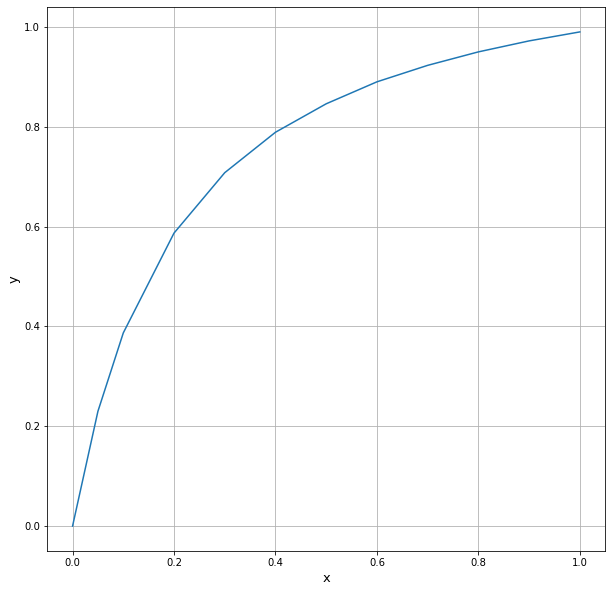

In [10]:
plt.figure(figsize=(10, 10))
line1, = plt.plot(x1, y_calc)
# plt.legend(handles=[line1], loc='best')
plt.xlabel("x", fontsize=13)
plt.ylabel("y",fontsize=13)
plt.grid()
plt.show()

## Non-ideal v-l curve


In [11]:
def solve2(P_, x):
    n=0
    tol=0.01
    T=300
    y1=0
    while True:
        y1=(x*Y1(x,T)*Pb_0(T)*phi_b_sat(T))/(P_*phi_b(T))
        y2=((1-x)*Y2(1-x,T)*Pm_0(T)*phi_m_sat(T))/(P_*phi_m(T))
        if(y1+y2<1+tol and y1+y2>1-tol):
            break
        elif(y1+y2>1+tol):
            T-=0.01
        else:
            T+=0.01
        if(n>5000):
            break
        n+=1
    ans=np.array([y1,T])
    return ans

In [12]:
P_=20
y1_calc2=[]
T_calc2=[]
for i in range(13):
    ans=solve2(P_,df.iloc[i][1])
    y1_calc2.append(round(ans[0],3))
    T_calc2.append(round(ans[1],3))

In [13]:
df['T_calc(K)2']=pd.DataFrame(T_calc2)
df['y_calc2']=pd.DataFrame(y1_calc2)
print(df)

    T(deg C)   x1   y1   T(K)  T_calc(K)_1  y_calc_1  T_calc(K)2 y_calc2
0      72.50 0.00 0.00 345.65       345.57      0.00      331.13       0
1      67.02 0.05 0.17 340.17       341.51      0.23      330.13   0.196
2      64.40 0.10 0.32 337.55       338.19      0.39      328.87   0.356
3      60.23 0.20 0.53 333.38       333.01      0.59      326.23   0.580
4      56.65 0.30 0.68 329.80       329.06      0.71      323.84   0.715
5      53.34 0.40 0.80 326.49       325.90      0.79      321.85   0.799
6      50.40 0.50 0.86 323.55       323.27      0.85      320.23   0.856
7      48.12 0.60 0.92 321.27       321.04      0.89      318.90   0.896
8      46.05 0.70 0.95 319.20       319.10      0.92      317.77   0.926
9      44.15 0.80 0.98 317.30       317.39      0.95      316.73   0.951
10     42.50 0.90 0.99 315.65       315.86      0.97      315.67   0.972
11     41.90 0.95 1.00 315.05       315.15      0.98      315.10   0.981
12     41.20 1.00 1.00 314.35       314.48      0.9

### Plot:

In [14]:
x1_= df['x1'].to_numpy()
y1_= df['y1'].to_numpy()
y_calc_= df['y_calc2'].to_numpy()

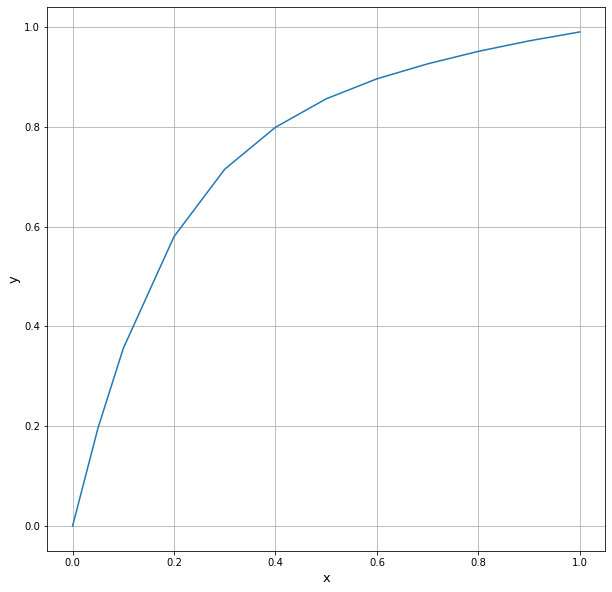

In [15]:
plt.figure(figsize=(10, 10))
line1, = plt.plot(x1_, y_calc_)
# plt.legend(handles=[line1], loc='best')
plt.xlabel("x", fontsize=13)
plt.ylabel("y",fontsize=13)
plt.grid()
plt.show()

# Q1: For non-ideal system:
## From your previous assignment, you have drawn a Y Vs X (vapour equilibrium)curve assuming the system to be non-ideal. Now for the same selected system, you have to find the followings:
### 1. Actual number of stages(trays) required to achieve separation(with graph) in a Distillation column with the help of McCabe-Thiele method.


In [16]:
# #example values
# bp_c=0.2
# f_c=0.5
# tp_c=0.8
# R=0.289
# slope=R/(R+1)
# inter=tp_c/(R+1)

In [44]:
# for taking inputs
bp_c= float(input("Please enter Bottom product composition: "))
f_c= float(input("Please enter feed composition: "))
tp_c= float(input("Please enter Top product composition: "))
R= float(input("Please enter Reflux ratio: "))
slope=R/(R+1)
inter=tp_c/(R+1)

Please enter Bottom product composition: 0.1
Please enter feed composition: 0.4
Please enter Top product composition: 0.9
Please enter Reflux ratio: 0.88


In [18]:
def objective(x, a, b, c, d):
    return a * (x**3) + b*(x**2) + c*x + d
popt, _ = curve_fit(objective, x1, y_calc_)
a, b,c,d = popt
print(a,b,c,d)

2.2520716834757994 -4.811283161692931 3.542310058178783 0.02514567531963564


In [23]:
def f_(z):
    x,y = z
    return [y+x-2*f_c,y-a*x**3-b*(x**2)-c*x-d]

def _f_(z):
    x,y = z
    return [y-(slope*x+inter),y+x-2*f_c]

In [24]:
# feed line
l=fsolve(f_,[1,1])[0]
f_x=np.linspace(l,f_c,100)
f_y=-1*f_x+2*f_c

In [25]:
# enriching section
# take reflux ration from the user
z=fsolve(_f_,[1,1])
l=z[0]
t=z[1]
el_x=np.linspace(l,tp_c,100)
el_y=slope*el_x+inter

In [26]:
#stripping section
sc_x=np.linspace(bp_c,l,100)
#(bp_c,bp_c)(l,t)
sl=(t-bp_c)/(l-bp_c)
it=((l-t)/(l-bp_c))*bp_c
sc_y=sl*sc_x+it

In [27]:
#making stepping down plot
# for horizontal line
def f1(z,t):
    x,y = z
    return [y-t,y-a*x**3-b*(x**2)-c*x-d]

# for vertical line with enriching line
def f2(z,t):
    x,y = z
    return [x-t,y-((R/(R+1))*x+tp_c/(R+1))]

#for vertical line with stripping section
def f3(z,t):
    x,y = z
    return [x-t,y-sl*x-it]

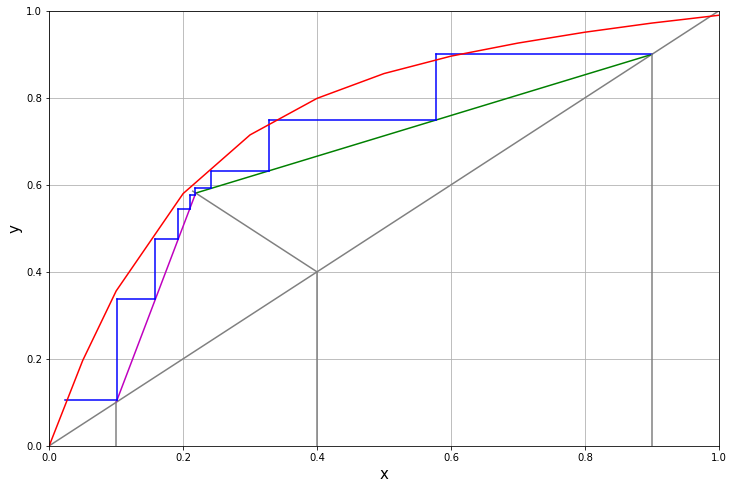

In [28]:
x = np.linspace(0,1,100)
y = x
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(x, y,color="0.5")
ax.plot(f_x,f_y,color="0.5")
ax.plot(el_x,el_y,color="g")
ax.plot(sc_x,sc_y,color="m")
x_=tp_c
y_=tp_c
f=0
count=0
while x_>=bp_c:
    if f==0:
        z=fsolve(f1,[1,1],y_)
        plt.axhline(y=y_,xmin=z[0],xmax=x_, color = 'b', linestyle = '-')
        x_=z[0]
        y_=z[1]
        f=1
        continue
    if f==1:
        count+=1
        if x_>=l and x_<=tp_c:
            z=fsolve(f2,[1,1],x_)
            plt.axvline(x = x_,ymin=z[1],ymax=y_, color = 'b', linestyle = '-')
            x_=z[0]
            y_=z[1]
            f=0 
            continue
        if x_<l:
            z=fsolve(f3,[1,1],x_)
            plt.axvline(x = x_,ymin=z[1],ymax=y_, color = 'b', linestyle = '-')
            x_=z[0]
            y_=z[1]
            f=0 
            continue
            
ax.set_ylim(bottom=0,top=1)
ax.set_xlim(left=0,right=1)
plt.axvline(x = bp_c,ymin=0,ymax=bp_c, color = '0.5', linestyle = '-')
plt.axvline(x = f_c,ymin=0,ymax=f_c, color = '0.5', linestyle = '-')
plt.axvline(x = tp_c,ymin=0,ymax=tp_c, color = '0.5', linestyle = '-')
plt.plot(0, f_c,color="0.5")
plt.plot(0, tp_c,color="0.5")
plt.plot(x1, y_calc_,color="r")
plt.xlabel("x", fontsize=15)
plt.ylabel("y",fontsize=15)
plt.grid()
plt.show()

In [29]:
#Number of trays used
print(count+1)

9


### 2. Minimum number of stages(trays) required to achieve their separation (with graph)


In [30]:
def f3(z,t):
    x,y = z
    return [x-t,y-x]

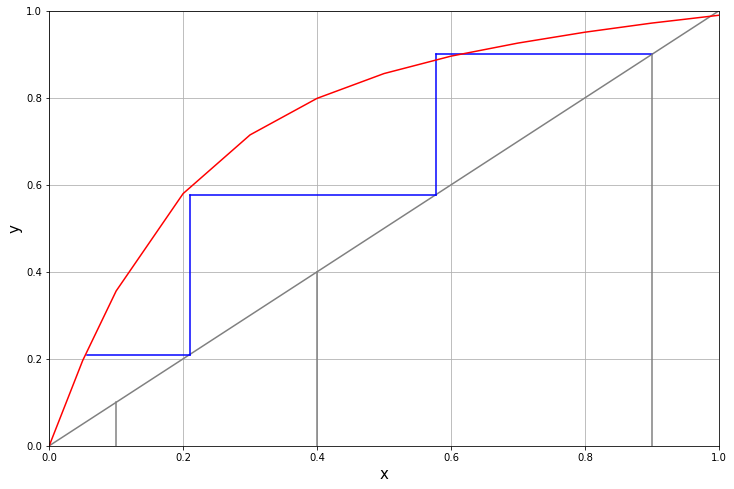

In [31]:
x = np.linspace(0,1,100)
y = x
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(x, y,color="0.5")
x_=tp_c
y_=tp_c
f=0
count=0
while x_>=bp_c:
    if f==0:
        z=fsolve(f1,[1,1],y_)
        plt.axhline(y=y_,xmin=z[0],xmax=x_, color = 'b', linestyle = '-')
        x_=z[0]
        y_=z[1]
        f=1
        continue
    if f==1:
        count+=1
        z=fsolve(f3,[1,1],x_)
        plt.axvline(x = x_,ymin=z[1],ymax=y_, color = 'b', linestyle = '-')
        x_=z[0]
        y_=z[1]
        f=0 
        continue 
ax.set_ylim(bottom=0,top=1)
ax.set_xlim(left=0,right=1)
plt.axvline(x = bp_c,ymin=0,ymax=bp_c, color = '0.5', linestyle = '-')
plt.axvline(x = f_c,ymin=0,ymax=f_c, color = '0.5', linestyle = '-')
plt.axvline(x = tp_c,ymin=0,ymax=tp_c, color = '0.5', linestyle = '-')
plt.plot(0, f_c,color="0.5")
plt.plot(0, tp_c,color="0.5")
plt.plot(x1, y_calc_,color="r")
plt.xlabel("x", fontsize=15)
plt.ylabel("y",fontsize=15)
plt.grid()
plt.show()

In [32]:
## Minimum number of trays used
print(count+1)

3


### 3. Minimum Reflux Ratio

In [34]:
z=fsolve(f_,[1,1])
x11=z[0]
y11=z[1]
#(x11,y11)(tp_c,tp_c)
sp=(tp_c-y11)/(tp_c-x11)
R_min=sp/(1-sp)
print(R_min)

0.8468526028967284


# Q2 : For ideal system:
### 1.

In [45]:
def objective(x, a, b, c, d):
    return a * (x**3) + b*(x**2) + c*x + d
popt, _ = curve_fit(objective, x1, y_calc)
a, b,c,d = popt
print(a,b,c,d)

2.2644595820893563 -4.754919273156312 3.455149217569548 0.04710822368363786


In [46]:
def f_(z):
    x,y = z
    return [y+x-2*f_c,y-a*x**3-b*(x**2)-c*x-d]

def _f_(z):
    x,y = z
    return [y-(slope*x+inter),y+x-2*f_c]

In [47]:
# feed line
l=fsolve(f_,[1,1])[0]
f_x=np.linspace(l,f_c,100)
f_y=-1*f_x+2*f_c

In [48]:
# enriching section
# take reflux ration from the user
z=fsolve(_f_,[1,1])
l=z[0]
t=z[1]
el_x=np.linspace(l,tp_c,100)
el_y=slope*el_x+inter

In [49]:
#stripping section
sc_x=np.linspace(bp_c,l,100)
#(bp_c,bp_c)(l,t)
sl=(t-bp_c)/(l-bp_c)
it=((l-t)/(l-bp_c))*bp_c
sc_y=sl*sc_x+it

In [50]:
#making stepping down plot
# for horizontal line
def f1(z,t):
    x,y = z
    return [y-t,y-a*x**3-b*(x**2)-c*x-d]

# for vertical line with enriching line
def f2(z,t):
    x,y = z
    return [x-t,y-((R/(R+1))*x+tp_c/(R+1))]

#for vertical line with stripping section
def f3(z,t):
    x,y = z
    return [x-t,y-sl*x-it]

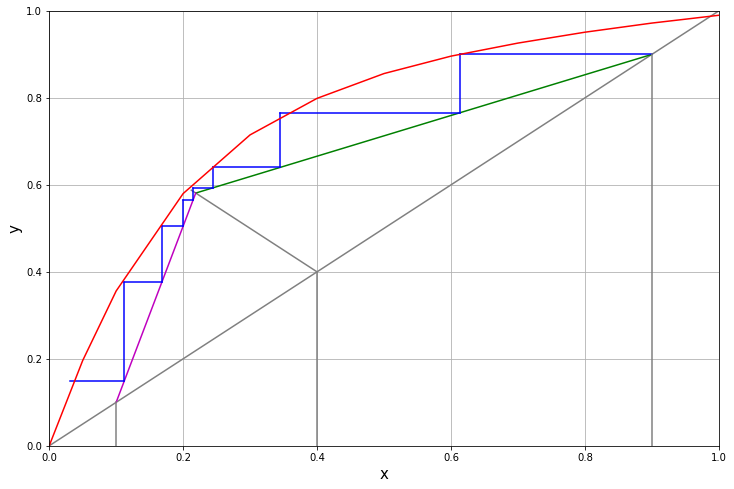

In [51]:
x = np.linspace(0,1,100)
y = x
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(x, y,color="0.5")
ax.plot(f_x,f_y,color="0.5")
ax.plot(el_x,el_y,color="g")
ax.plot(sc_x,sc_y,color="m")
x_=tp_c
y_=tp_c
f=0
count=0
while x_>=bp_c:
    if f==0:
        z=fsolve(f1,[1,1],y_)
        plt.axhline(y=y_,xmin=z[0],xmax=x_, color = 'b', linestyle = '-')
        x_=z[0]
        y_=z[1]
        f=1
        continue
    if f==1:
        count+=1
        if x_>=l and x_<=tp_c:
            z=fsolve(f2,[1,1],x_)
            plt.axvline(x = x_,ymin=z[1],ymax=y_, color = 'b', linestyle = '-')
            x_=z[0]
            y_=z[1]
            f=0 
            continue
        if x_<l:
            z=fsolve(f3,[1,1],x_)
            plt.axvline(x = x_,ymin=z[1],ymax=y_, color = 'b', linestyle = '-')
            x_=z[0]
            y_=z[1]
            f=0 
            continue
            
ax.set_ylim(bottom=0,top=1)
ax.set_xlim(left=0,right=1)
plt.axvline(x = bp_c,ymin=0,ymax=bp_c, color = '0.5', linestyle = '-')
plt.axvline(x = f_c,ymin=0,ymax=f_c, color = '0.5', linestyle = '-')
plt.axvline(x = tp_c,ymin=0,ymax=tp_c, color = '0.5', linestyle = '-')
plt.plot(0, f_c,color="0.5")
plt.plot(0, tp_c,color="0.5")
plt.plot(x1, y_calc_,color="r")
plt.xlabel("x", fontsize=15)
plt.ylabel("y",fontsize=15)
plt.grid()
plt.show()

In [52]:
## Number of trays used
print(count+1)

8


### 2.

In [53]:
def f3(z,t):
    x,y = z
    return [x-t,y-x]

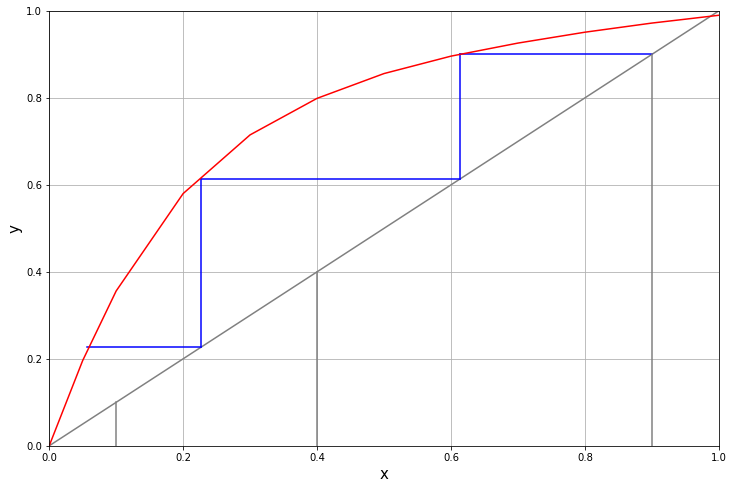

In [54]:
x = np.linspace(0,1,100)
y = x
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(x, y,color="0.5")
x_=tp_c
y_=tp_c
f=0
count=0
while x_>=bp_c:
    if f==0:
        z=fsolve(f1,[1,1],y_)
        plt.axhline(y=y_,xmin=z[0],xmax=x_, color = 'b', linestyle = '-')
        x_=z[0]
        y_=z[1]
        f=1
        continue
    if f==1:
        count+=1
        z=fsolve(f3,[1,1],x_)
        plt.axvline(x = x_,ymin=z[1],ymax=y_, color = 'b', linestyle = '-')
        x_=z[0]
        y_=z[1]
        f=0 
        continue 
ax.set_ylim(bottom=0,top=1)
ax.set_xlim(left=0,right=1)
plt.axvline(x = bp_c,ymin=0,ymax=bp_c, color = '0.5', linestyle = '-')
plt.axvline(x = f_c,ymin=0,ymax=f_c, color = '0.5', linestyle = '-')
plt.axvline(x = tp_c,ymin=0,ymax=tp_c, color = '0.5', linestyle = '-')
plt.plot(0, f_c,color="0.5")
plt.plot(0, tp_c,color="0.5")
plt.plot(x1, y_calc_,color="r")
plt.xlabel("x", fontsize=15)
plt.ylabel("y",fontsize=15)
plt.grid()
plt.show()

In [55]:
## Minimum number of trays used
print(count+1)

3


### 3.

In [57]:
z=fsolve(f_,[1,1])
x11=z[0]
y11=z[1]
#(x11,y11)(tp_c,tp_c)
sp=(tp_c-y11)/(tp_c-x11)
R_min=sp/(1-sp)
print(R)

0.88
